In [1]:
#pip install xgboost

***
## 1.  Definition of Prediction Problem <a id='c-1'></a>
***
The aim is to predict drought categories at the county level in the United States and at different periods of time as a function of weather and soil conditions. These categories align with the classifications established by the [US Drought Monitor](https://droughtmonitor.unl.edu/CurrentMap.aspx) and include No Drought and five additional categories as outlined below:

![Drought Categories](img/D_categories.png)

**Important: Geographic and Time Constraints**

* To address the challenges associated with a large dataset, which can lead to extended training times and high resource consumption for the model trainings, we decided to narrow our focus to the [Mountain West States](https://en.wikipedia.org/wiki/Western_United_States) of the United States.
*  Likewise, the years included in each of the datasets are the followings:
    * Training: 2008 to 2018
    * Testing: 2019 & 2020


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve,cross_val_score
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.model_selection import learning_curve
import os
import time
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold,StratifiedShuffleSplit,TimeSeriesSplit
import joblib
import xgboost as xgb
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, label_binarize
from typing import Dict


***
## 2. Training and Testing Datasets Loading <a id='c-2'></a>
***

In [3]:
#Load data
# Load Training and Testing datasets
data_dir = 'Data'

# Define the list of datasets to be loaded
dataframes = ['train_modified', 'test_modified','validation_modified']

# Load the datasets
datasets = {}
for df_name in dataframes:
    file_name = f'{df_name}.csv'
    file_path = os.path.join(data_dir, file_name)
    datasets[df_name] = pd.read_csv(file_path)

# Access the datasets using their keys
train_df = datasets['train_modified']
test_df = datasets['test_modified']
val_df=datasets['validation_modified']

# Change the data type of columns starting with "SQ" to uint8
for df in [train_df, test_df]:
    for column in df.columns:
        if column.startswith("SQ"):
            df[column] = df[column].astype("uint8")

In [4]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131600 entries, 0 to 131599
Data columns (total 74 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PRECTOT        131600 non-null  float64
 1   PS             131600 non-null  float64
 2   QV2M           131600 non-null  float64
 3   T2M            131600 non-null  float64
 4   T2MDEW         131600 non-null  float64
 5   T2MWET         131600 non-null  float64
 6   T2M_MAX        131600 non-null  float64
 7   T2M_MIN        131600 non-null  float64
 8   T2M_RANGE      131600 non-null  float64
 9   TS             131600 non-null  float64
 10  WS10M          131600 non-null  float64
 11  WS10M_MAX      131600 non-null  float64
 12  WS10M_MIN      131600 non-null  float64
 13  WS10M_RANGE    131600 non-null  float64
 14  WS50M          131600 non-null  float64
 15  WS50M_MAX      131600 non-null  float64
 16  WS50M_MIN      131600 non-null  float64
 17  WS50M_RANGE    131600 non-nul

In [5]:
test_df.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,SQ5_7,SQ6_2,SQ6_3,SQ6_6,SQ6_7,SQ7_2,SQ7_3,SQ7_4,SQ7_6,SQ7_7
0,1.16,79.77,1.67,-9.04,-13.63,-12.80,-4.79,-15.88,11.10,-9.82,...,0,0,0,0,0,0,0,0,0,0
1,0.00,80.85,3.37,1.10,-4.52,-4.40,8.86,-3.27,12.12,-0.28,...,0,0,0,0,0,0,0,0,0,0
2,1.33,80.43,4.56,2.29,-0.55,-0.54,7.96,-2.09,10.05,1.84,...,0,0,0,0,0,0,0,0,0,0
3,0.08,80.02,2.27,-2.87,-9.77,-9.24,1.81,-6.37,8.17,-2.30,...,0,0,0,0,0,0,0,0,0,0
4,0.00,80.09,2.24,1.03,-10.03,-9.27,6.05,-2.48,8.53,0.15,...,0,0,0,0,0,0,0,0,0,0


In [6]:
val_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRECTOT        29120 non-null  float64
 1   PS             29120 non-null  float64
 2   QV2M           29120 non-null  float64
 3   T2M            29120 non-null  float64
 4   T2MDEW         29120 non-null  float64
 5   T2MWET         29120 non-null  float64
 6   T2M_MAX        29120 non-null  float64
 7   T2M_MIN        29120 non-null  float64
 8   T2M_RANGE      29120 non-null  float64
 9   TS             29120 non-null  float64
 10  WS10M          29120 non-null  float64
 11  WS10M_MAX      29120 non-null  float64
 12  WS10M_MIN      29120 non-null  float64
 13  WS10M_RANGE    29120 non-null  float64
 14  WS50M          29120 non-null  float64
 15  WS50M_MAX      29120 non-null  float64
 16  WS50M_MIN      29120 non-null  float64
 17  WS50M_RANGE    29120 non-null  float64
 18  score 

In [7]:
#  Concatenate the validation data to the training data
train_df = pd.concat([train_df, val_df], axis=0)

# Reset the index of the merged DataFrame
train_df.reset_index(drop=True, inplace=True)

In [8]:
print(train_df.columns)

Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE',
       'score', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3',
       'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE',
       'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND',
       'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND', 'doy',
       'year', 'SQ1_2', 'SQ1_3', 'SQ1_6', 'SQ1_7', 'SQ2_2', 'SQ2_3', 'SQ2_6',
       'SQ2_7', 'SQ3_2', 'SQ3_3', 'SQ3_4', 'SQ3_6', 'SQ3_7', 'SQ4_2', 'SQ4_6',
       'SQ4_7', 'SQ5_2', 'SQ5_3', 'SQ5_4', 'SQ5_6', 'SQ5_7', 'SQ6_2', 'SQ6_3',
       'SQ6_6', 'SQ6_7', 'SQ7_2', 'SQ7_3', 'SQ7_4', 'SQ7_6', 'SQ7_7'],
      dtype='object')


In [9]:
#target and independent variables
x_train=train_df.drop(["score"],axis=1)
x_test=test_df.drop(["score"],axis=1)
y_train=train_df['score']
y_test=test_df['score']


In [10]:
x_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29400 entries, 0 to 29399
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRECTOT        29400 non-null  float64
 1   PS             29400 non-null  float64
 2   QV2M           29400 non-null  float64
 3   T2M            29400 non-null  float64
 4   T2MDEW         29400 non-null  float64
 5   T2MWET         29400 non-null  float64
 6   T2M_MAX        29400 non-null  float64
 7   T2M_MIN        29400 non-null  float64
 8   T2M_RANGE      29400 non-null  float64
 9   TS             29400 non-null  float64
 10  WS10M          29400 non-null  float64
 11  WS10M_MAX      29400 non-null  float64
 12  WS10M_MIN      29400 non-null  float64
 13  WS10M_RANGE    29400 non-null  float64
 14  WS50M          29400 non-null  float64
 15  WS50M_MAX      29400 non-null  float64
 16  WS50M_MIN      29400 non-null  float64
 17  WS50M_RANGE    29400 non-null  float64
 18  lat   

In [11]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 2


***
## 3. Understanding the XGBoost model  <a id='c-3'></a>
***

#### 3.1. Extreme Gradient Boosting Algorithm: XGBoost <a id='c3'></a>

Traditional gradient boosting algorithms operate based on the principle that weak learners can be modified using the following elements:

- A loss function to be optimized.
- A weak learner to make initial predictions (e.g., a greedily constructed decision tree).
- An additive model used to add weak learners to minimize the loss function.

However, these models can be slow due to their sequential nature. This led to the development of XGBoost, designed for speed and high performance by enabling parallelization, distributed computing, out-of-cache computing, and cache optimization.

In this task, we employed XGBoost directly in the scikit-learn framework using the wrapper class, `XGBClassifier`. The model is trained by constructing and calling the `model.fit` function.

##### Monitoring Performance and Early Stopping

During the training process, a validation dataset and an evaluation metric are explicitly specified when calling `model.fit`. The selection of the evaluation metric is crucial and depends on the nature of the problem. Given our goal of multiclass classification, several appropriate metrics can be considered, including `merror` and `mlogloss`. Additionally, metrics like `auc` are ideal, especially for imbalanced datasets.

##### Choice of Evaluation Metric

- **merror:** Multiclass classification error rate. It calculates the proportion of misclassified instances.

- **mlogloss:** Multiclass logloss. It measures the performance of a classification model where the prediction is a probability value between 0 and 1.

- **auc:** Area Under the Receiver Operating Characteristic (ROC) curve. It is particularly useful for imbalanced datasets.


To prevent overfitting, the `early_stopping_rounds` parameter is introduced. This setting halts the training process once a specified number of iterations is reached, beyond which there is no further improvement in the model's performance.

The iterative evaluation of the model's progress, coupled with the appropriate choice of evaluation metric and early stopping criteria, ensures that the training process is optimized for the specific challenges of the multiclass classification task, striking a balance between model complexity and generalization.


The strategy includes the following steps:
1. Run the default model, i.e., use all default parameters, and review the model fit on learning curves.
2. If overfitting or underfitting is observed, optimize parameters such as learning rate, regularization parameters, and feature subsampling.

This iterative approach ensures that the model is tuned effectively for the specific task, striking a balance between model complexity and generalization.


##### The model parameters

XGBoost has three types od parameters: general parameters,booster parameters and learning task parameters [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html): The parameters that we considered for
this task are the booster and learning task parameters. 

###### Booster parameters

| Parameter Name             | Selected Value       | Explanation                                                                                                           |
|---------------------------|-----------------------|-----------------------------------------------------------------------------------------------------------------------|
| `learning_rate`             | 0.1                 | determines the contribution of each tree to the final prediction. A lower learning rate requires a higher number of trees to achieve good performance.|
| `gamma`                | default=0      | The minimum loss reduction to further split the leaf node.                   |                                            |
| `max_depth`               | default=5         | The maximum  depth of trees which determines complexity of the model      |
| `min_child_weight` | default=2             | Stops further splitting if the sum of the instance weight in a leaf node is less than the provided value               |
| `subsample` | 0.8    | To prevent overfitting, 80% of the training data would be sampled prior to growing trees. >= 50%(0.5) is recommended for good results.                                                                             |
| `sampling_method`            | default="uniform"      | Each training instance has equal probability of selection for tree growing |
| `colsample_bynode/tree/level`       | default=1        | The fraction of columns to be sampled                                                                          |
| `reg_lambda` | default=1    | L2 regularization parameter.                                                                  |
| `reg_alpha`                | default=0       | L1 regularization parameter.                                                                  |
| `tree_method`              | default=auto | The fast histogram optimized approximate greedy algorithm will be used for tree construction |
| `scale_pos_weight`                    | 1                     | Takes care of the imbalanced class distribution                                                           |


###### Learning parameters 

| Parameter Name             | Selected Value       | Explanation                                                                                                           |
|---------------------------|-----------------------|-----------------------------------------------------------------------------------------------------------------------|
| `objective`             | multi:softprob                   | Our goal is a muticlass classiffication. softprob, is like softmax but outputs predicted probability. |
| `eval_metric`                | auc       | The default for muticlass softprob classification                                                                |

##### Feature importance

***
## 4. Function definition  <a id='c-4'></a>
***


For a more readable notebook, we defined three models:

* One for evaluating model performance and plotting the confusion matrix
* The second for plotting learning curves to establish how various parameters behave at training and generalization
* The third to test and tune various hyperparameter values



In [12]:
# Test Model's Performance
def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate the performance of the classification model and plot a confusion matrix.

    Parameters:
    - y_true: true labels for the data
    - y_pred: predicted labels from the model
    """
    # Define the class labels
    
    # Generate a classification report
    print(classification_report(y_true, y_pred, target_names=['No Drought', 'D0','D1','D2','D3','D4']))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a ConfusionMatrixDisplay object and plot the confusion matrix
    sns.set(style='dark')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Drought', 'D0','D1','D2','D3','D4'])
    plt.figure(figsize=(4, 4))
    disp.plot()

 

**Understanding Learning Curves in Model Training**

During the training process, diagnostic tools are crucial for evaluating the performance of a machine learning model. Learning curves provide visualizations that depict the changes in performance over time, helping to assess whether the model is fitting the data appropriately or if there are signs of overfitting or underfitting.

**Role of Training and Validation Datasets**

Learning curves are constructed using the training dataset, showcasing how the model performs on the data it has seen. Simultaneously, the validation or test dataset helps us gauge how well the model generalizes to unseen data.

**Importance of Metrics**

The choice of evaluation metric is paramount. For metrics that are maximized (e.g., accuracy), we aim to increase them over time. Conversely, for metrics like loss or error, which are minimized, the goal is to decrease them until the model converges.

**Types of Curves**

***Optimization Curve***
When using a loss or error metric, we generate an optimization curve. The goal is to minimize this metric as the model's parameters are adjusted during training.

***Learning Curve***
When employing a performance metric (e.g., accuracy), we obtain a learning curve. Accuracy increases as the model learns, providing insights into how well it generalizes to new data.


**Plotting Curves**

Typically, both the training and validation curves are plotted together. This allows us to observe trends, identify convergence, and understand whether the datasets used are representative of the problem being addressed.

**Multiple Metrics**

In cases where multiple metrics, such as cross-entropy and classification accuracy, are considered, it's common to plot two sets of curves. Each set includes both the training and validation learning curves, providing a comprehensive view of the model's performance across different aspects.



In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, learning_curve

def val_curve_params(model, X, y, scoring="roc_auc_ovr", cv=None):
    """
    Plot the influence of a single hyperparameter on the training score and the validation score
    to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

    Parameters:
    model (estimator): The machine learning model for which the learning curve should be plotted.
    X (array-like): The feature matrix.
    y (array-like): The true labels.
    scoring (str, optional): The scoring metric to use. Default is "roc_auc_ovr".
    cv (int or cross-validation generator, optional): Determines the cross-validation splitting strategy.
        If None, it uses TimeSeriesSplit with default parameters.
    """
    
    if cv is None:
        cv = TimeSeriesSplit(n_splits=5, gap=12, max_train_size=130000, test_size=20000)

    common_params = {
        "estimator": model,
        "X": X,
        "y": y,
        "cv": cv,
        "scoring": scoring,
        "n_jobs": 4,
        "train_sizes": [0.1, 0.25, 0.5, 0.75, 1.0],
    }

    # Using learning_curve to get training and validation scores
    train_sizes, train_scores, test_scores = learning_curve(**common_params)

    # Plotting learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), marker='o', label='Test Score')

    # Filling the standard deviation in the learning curve
    plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                     train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1),
                     test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.1)

    # Adding labels and title
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()




In [14]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit, validation_curve
# from sklearn.model_selection import learning_curve

# def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc_ovr"):
#     """
#     Plot the influence of a single hyperparameter on the training score and the validation score to 
#     find out whether the estimator is overfitting or underfitting for some hyperparameter values.
#     Parameters:
#     model: The machine learning model (estimator) for which you want to plot the validation curve.
#     X (array-like): The feature matrix of the data.
#     y (array-like): The target variable.
#     param_name (str): The name of the hyperparameter to vary.
#     param_range (array-like): The values of the hyperparameter to try.
#     scoring (str): The scoring metric to use for cross-validation.
#     """
    
#     common_params = {
#         "estimator": model,
#         "X": X,
#         "y": y,
#         "cv": TimeSeriesSplit(n_splits=5, gap=12, max_train_size=130000, test_size=20000),
#         "scoring": scoring,
#         "n_jobs": 4,
#     }

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(**common_params, train_sizes=np.linspace(0.1, 1.0, 5))

#     plt.figure(figsize=(10, 6))

#     plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
#     plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")

#     plt.title("Learning Curve")
#     plt.xlabel("Training Examples")
#     plt.ylabel("Score")
#     plt.legend(loc="best")
#     plt.show()




**Blocked Timeseries split cross-validation**

In [15]:
#test blocked time series cross validation
tscv=TimeSeriesSplit(n_splits=5, gap=12,max_train_size=130000,test_size=20000)
all_splits=list(tscv.split(x_train,y_train))
train_0,test_0=all_splits[0]
#x_train.iloc[test_0]

train_4,test_4=all_splits[4]
x_train.iloc[test_4]

# X = np.random.randn(12, 2)
# >>> y = np.random.randint(0, 2, 12)
# >>> tscv = TimeSeriesSplit(n_splits=3, test_size=2)
# >>> for i, (train_index, test_index) in enumerate(tscv.split(X)):
# print(f"Fold {i}:")
# print(f"  Train: index={train_index}")
# print(f"  Test:  index={test_index}")

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,SQ5_7,SQ6_2,SQ6_3,SQ6_6,SQ6_7,SQ7_2,SQ7_3,SQ7_4,SQ7_6,SQ7_7
140720,0.13,89.99,8.80,18.48,10.52,10.35,25.61,9.38,16.23,17.21,...,0,0,0,0,0,1,0,0,0,0
140721,0.06,89.90,7.25,12.66,7.64,7.56,18.04,7.88,10.16,12.77,...,0,0,0,0,0,1,0,0,0,0
140722,0.11,90.06,6.07,12.10,5.08,5.00,17.09,6.34,10.76,11.21,...,0,0,0,0,0,1,0,0,0,0
140723,0.03,90.38,5.43,10.33,3.55,3.38,16.31,2.32,13.99,9.69,...,0,0,0,0,0,1,0,0,0,0
140724,0.15,90.56,9.08,16.87,11.09,10.96,22.50,9.08,13.41,16.30,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160715,0.21,82.62,2.88,-0.63,-6.30,-6.25,5.40,-5.43,10.83,-1.94,...,0,0,0,0,0,0,0,0,0,0
160716,0.01,83.32,1.47,-7.66,-14.71,-13.42,-1.41,-11.86,10.45,-8.96,...,0,0,0,0,0,0,0,0,0,0
160717,0.06,82.94,2.12,-3.04,-10.21,-9.60,2.45,-6.68,9.13,-4.08,...,0,0,0,0,0,0,0,0,0,0
160718,0.06,82.77,3.09,0.69,-5.36,-5.17,5.77,-4.12,9.89,-1.31,...,0,0,0,0,0,0,0,0,0,0


In [38]:

#a function to tune the parameters
def tune_params(model, train_x, train_y, params: Dict[str, any]):
    """
    Evaluate the model performance for various parameter values

    Parameters:
    model (estimator): The classification model for which the mean roc auc is generated.
    train_x (array-like): The feature matrix of the training data.
    train_y (array-like): The true labels of the training data.
    """

    #cross-validation for model selection
    #IT IS IMPORTANT TO NOTE THAT WE NEED TO PRESERVE THE TEMPORAL DEPENDENCY BETWEEN OBSERVATIONS DURING TESTING
    #cross-validation on a rolling basis: suffling is not approporiate
    
    
    tscv=TimeSeriesSplit(n_splits=5, gap=12,max_train_size=130000,test_size=20000)
   
    grid_search = GridSearchCV(model, param_grid=params, scoring="roc_auc", cv=tscv, verbose=1)

    grid_search.fit(train_x, train_y)

    # Accessing the results
    cv_results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    # Displaying all CV results
    print("\nCV Results:")
    for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
        print(f"Mean ROC AUC: {mean_score:.5f}, Params: {params}")




***
## 5. Baseline model, with default parameters <a id='c-5'></a>
***

In [17]:
# Use "hist" for constructing the trees, with early stopping enabled.

clf_0= xgb.XGBClassifier()
clf_0.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

  No Drought       0.68      0.47      0.56     14698
          D0       0.22      0.24      0.23      5534
          D1       0.19      0.19      0.19      4074
          D2       0.13      0.23      0.17      2594
          D3       0.12      0.23      0.16      1888
          D4       0.13      0.20      0.16       612

    accuracy                           0.35     29400
   macro avg       0.25      0.26      0.24     29400
weighted avg       0.43      0.35      0.38     29400



<Figure size 400x400 with 0 Axes>

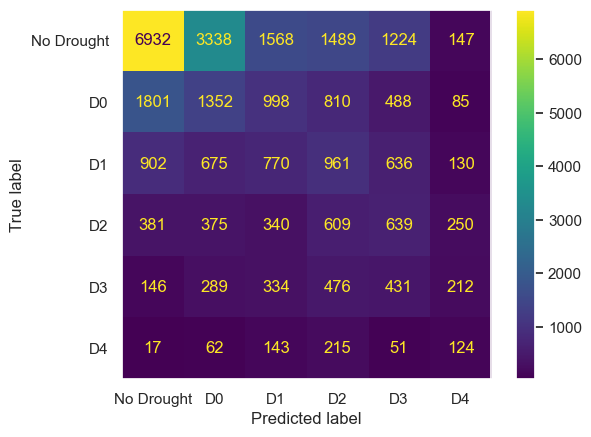

In [18]:
y_pred_0 = clf_0.predict(x_test)
evaluate_model_performance(y_test,y_pred_0)

This model performs poorly and is biased toward the majority classes. Hence we have to address it. There are two three ways to do this, two of which are model based and one is data based. The model based techniques are:
1. balancing of positives and negatives via scale_pos_weight to improve the overall performance metric, in this case AUC
2. to ensure we are predicting the right probability, we set the parameter max_delta_step to a finite number(between 1 and 10) for convergence.
The data based method involves creating of synthetic data in an attempt to balance the class distribution.

***
## 6. Managing class imbalance <a id='c-6'></a>
***

### 6.1 With SMOTE


"SMOTE first selects a minority class instance at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b" (He & Ma, 2013)

In [19]:
# Oversampling dataset with SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

# Create a StandardScaler object to standardize the data.
scaler = StandardScaler()
# Fit the scaler to the training data to compute mean and standard deviation.
scaler.fit(x_train)
# Transform the training data using the computed mean and standard deviation.
scaled_x_train = scaler.transform(x_train)
# Transform the test data using the same scaler.
scaled_x_test = scaler.transform(x_test)
sm = SMOTE(random_state=44)
smote_x_train, smote_y_train = sm.fit_resample(scaled_x_train, y_train)

              precision    recall  f1-score   support

  No Drought       0.00      0.00      0.00     14698
          D0       0.19      0.65      0.29      5534
          D1       0.17      0.37      0.23      4074
          D2       0.14      0.05      0.08      2594
          D3       0.00      0.00      0.00      1888
          D4       0.00      0.00      0.00       612

    accuracy                           0.18     29400
   macro avg       0.08      0.18      0.10     29400
weighted avg       0.07      0.18      0.09     29400



<Figure size 400x400 with 0 Axes>

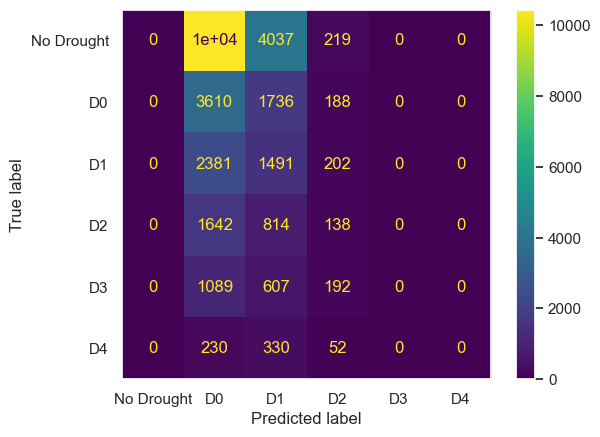

In [20]:
clf_0.fit(smote_x_train,smote_y_train)
y_pred_smote = clf_0.predict(x_test)
evaluate_model_performance(y_test,y_pred_smote)

### 6.2 With scale_pos_weight and max_delta_step parameters


              precision    recall  f1-score   support

  No Drought       0.68      0.46      0.55     14698
          D0       0.23      0.24      0.24      5534
          D1       0.15      0.11      0.13      4074
          D2       0.12      0.15      0.14      2594
          D3       0.11      0.33      0.16      1888
          D4       0.10      0.34      0.16       612

    accuracy                           0.33     29400
   macro avg       0.23      0.27      0.23     29400
weighted avg       0.43      0.33      0.36     29400



<Figure size 400x400 with 0 Axes>

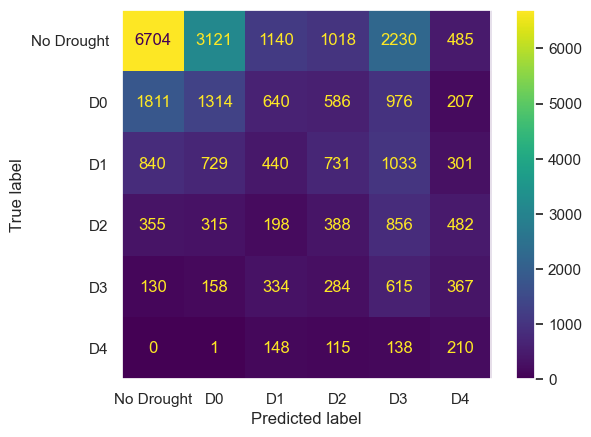

In [21]:

# Calculate class weights
class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

# Assign weights to samples in the training set
sample_weights = [class_weights[label] for label in y_train]

# Create DMatrix with weights
dtrain = xgb.DMatrix(x_train, label=y_train, weight=sample_weights)
params = {
    'objective': 'multi:softmax',  # for multiclass classification
    'num_class': len(np.unique(y_train)),  # number of classes
    'eval_metric': 'auc',  # or other appropriate metric
    # other parameters...
}

# Train the model
clf_1 = xgb.train(params, dtrain)

# Predictions on the test set
y_pred1 = clf_1.predict(xgb.DMatrix(x_test))

# Evaluate accuracy
evaluate_model_performance(y_test,y_pred1)

              precision    recall  f1-score   support

  No Drought       0.68      0.47      0.56     14698
          D0       0.23      0.25      0.24      5534
          D1       0.18      0.19      0.19      4074
          D2       0.13      0.23      0.17      2594
          D3       0.13      0.23      0.16      1888
          D4       0.13      0.21      0.16       612

    accuracy                           0.35     29400
   macro avg       0.25      0.26      0.25     29400
weighted avg       0.43      0.35      0.38     29400



<Figure size 400x400 with 0 Axes>

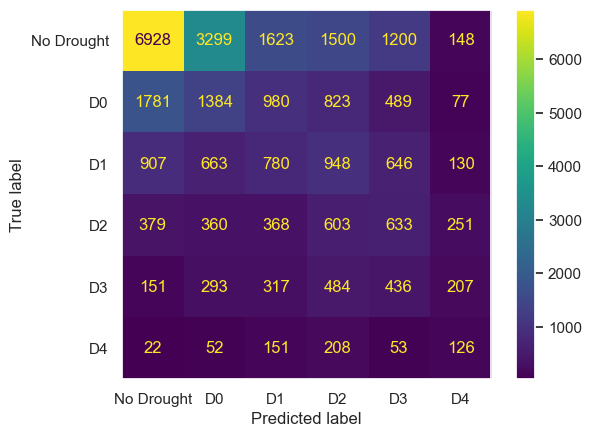

In [22]:
clf_2 = xgb.XGBClassifier(scale_pos_weight=1,max_delta_step=5)
clf_2.fit(x_train,y_train)
y_pred_2 = clf_2.predict(x_test)
evaluate_model_performance(y_test,y_pred_2)

              precision    recall  f1-score   support

  No Drought       0.68      0.47      0.56     14698
          D0       0.23      0.25      0.24      5534
          D1       0.18      0.19      0.19      4074
          D2       0.13      0.23      0.17      2594
          D3       0.13      0.23      0.16      1888
          D4       0.13      0.21      0.16       612

    accuracy                           0.35     29400
   macro avg       0.25      0.26      0.25     29400
weighted avg       0.43      0.35      0.38     29400



<Figure size 400x400 with 0 Axes>

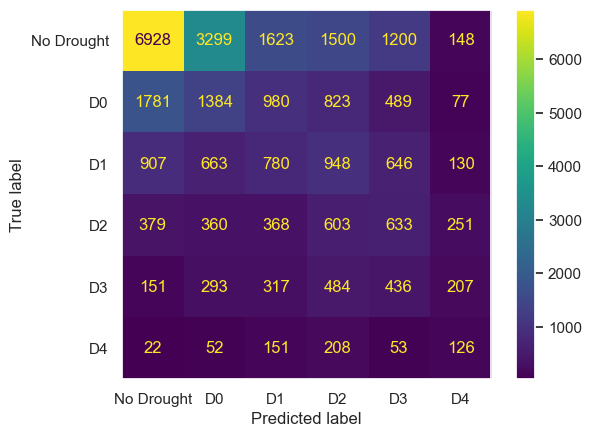

In [23]:
#combining all 
clf_3 = xgb.XGBClassifier(scale_pos_weight=1,max_delta_step=5)
clf_3.fit(smote_x_train,smote_y_train)
y_pred_3 = clf_2.predict(x_test)
evaluate_model_performance(y_test,y_pred_3)

***
## 7. Test Initial Parameter Values and Implement Early Stopping <a id='c-7'></a>
***


With XGBoost, it's beneficial to test initial values of various parameters while closely monitoring the performance of the model. A crucial aspect is to avoid overfitting, and we can achieve this by utilizing early stopping.

#### Early Stopping in XGBoost

We can monitor the performance of the model by specifying both a validation dataset and an evaluation metric during the training process. This reports the performance of the model after each tree. Early stopping involves stopping the training process once no further improvements have been made on the validation dataset.

The loss/error tends to decrease during training, and early stopping is triggered if the  loss on the validation set does not improve for a specified number of consecutive rounds.


In [24]:

clf_3 = xgb.XGBClassifier(
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 reg_lambda=1,
 reg_alpha=0,
 scale_pos_weight=1)


#### Without early stopping

In [25]:
# Fit the model, test 
start = time.time()
eval_set = [(x_train,y_train),(x_test, y_test)]
clf_3.fit(x_train, y_train,eval_metric="mlogloss",eval_set=eval_set,verbose=True)  #or auc when objective is set to multi:softprob

end = time.time()
print('Execution time for Training clf1:', end - start, "seconds")
# Save model into JSON format.
clf_3.save_model("clf1.json")

[0]	validation_0-mlogloss:1.72335	validation_1-mlogloss:1.73683
[1]	validation_0-mlogloss:1.65125	validation_1-mlogloss:1.70129
[2]	validation_0-mlogloss:1.58831	validation_1-mlogloss:1.66543
[3]	validation_0-mlogloss:1.54125	validation_1-mlogloss:1.63127
[4]	validation_0-mlogloss:1.49979	validation_1-mlogloss:1.60261
[5]	validation_0-mlogloss:1.46494	validation_1-mlogloss:1.57618
[6]	validation_0-mlogloss:1.42310	validation_1-mlogloss:1.55643
[7]	validation_0-mlogloss:1.39366	validation_1-mlogloss:1.53595
[8]	validation_0-mlogloss:1.36177	validation_1-mlogloss:1.52408
[9]	validation_0-mlogloss:1.33216	validation_1-mlogloss:1.51218
[10]	validation_0-mlogloss:1.30713	validation_1-mlogloss:1.50059
[11]	validation_0-mlogloss:1.28426	validation_1-mlogloss:1.49084
[12]	validation_0-mlogloss:1.26133	validation_1-mlogloss:1.48157
[13]	validation_0-mlogloss:1.24250	validation_1-mlogloss:1.47314
[14]	validation_0-mlogloss:1.22303	validation_1-mlogloss:1.46686
[15]	validation_0-mlogloss:1.20542	

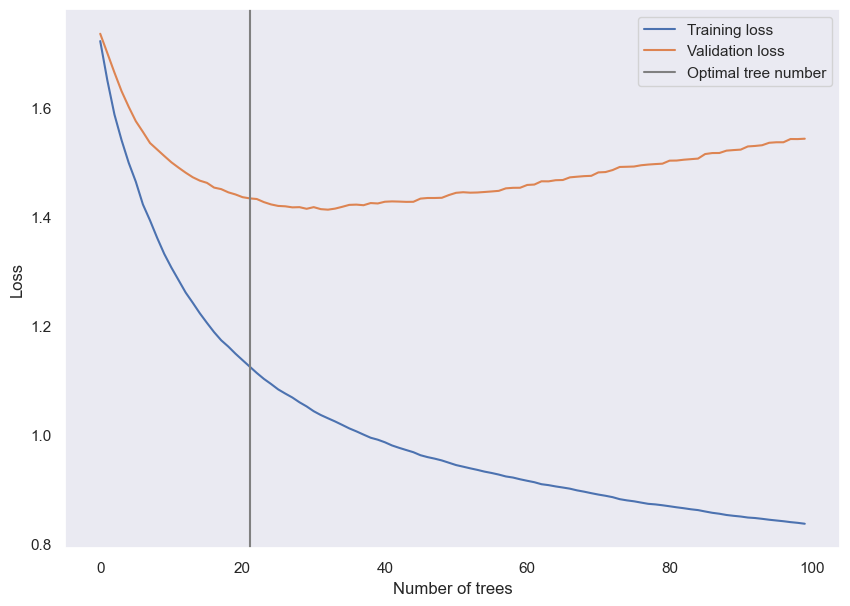

In [26]:
results = clf_3.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

### With early stopping


In [27]:
# Fit the model, test sets are used for early stopping.
start = time.time()
eval_set = [(x_train,y_train),(x_test, y_test)]
clf_3.fit(x_train, y_train,eval_metric="mlogloss",eval_set=eval_set, early_stopping_rounds=50,verbose=True)  #or auc when objective is set to multi:softprob

end = time.time()
print('Execution time for Training clf1:', end - start, "seconds")
# Save model into JSON format.
clf_3.save_model("clf2.json")

[0]	validation_0-mlogloss:1.72335	validation_1-mlogloss:1.73683
[1]	validation_0-mlogloss:1.65125	validation_1-mlogloss:1.70129
[2]	validation_0-mlogloss:1.58831	validation_1-mlogloss:1.66543
[3]	validation_0-mlogloss:1.54125	validation_1-mlogloss:1.63127
[4]	validation_0-mlogloss:1.49979	validation_1-mlogloss:1.60261
[5]	validation_0-mlogloss:1.46494	validation_1-mlogloss:1.57618
[6]	validation_0-mlogloss:1.42310	validation_1-mlogloss:1.55643
[7]	validation_0-mlogloss:1.39366	validation_1-mlogloss:1.53595
[8]	validation_0-mlogloss:1.36177	validation_1-mlogloss:1.52408
[9]	validation_0-mlogloss:1.33216	validation_1-mlogloss:1.51218
[10]	validation_0-mlogloss:1.30713	validation_1-mlogloss:1.50059
[11]	validation_0-mlogloss:1.28426	validation_1-mlogloss:1.49084
[12]	validation_0-mlogloss:1.26133	validation_1-mlogloss:1.48157
[13]	validation_0-mlogloss:1.24250	validation_1-mlogloss:1.47314
[14]	validation_0-mlogloss:1.22303	validation_1-mlogloss:1.46686
[15]	validation_0-mlogloss:1.20542	

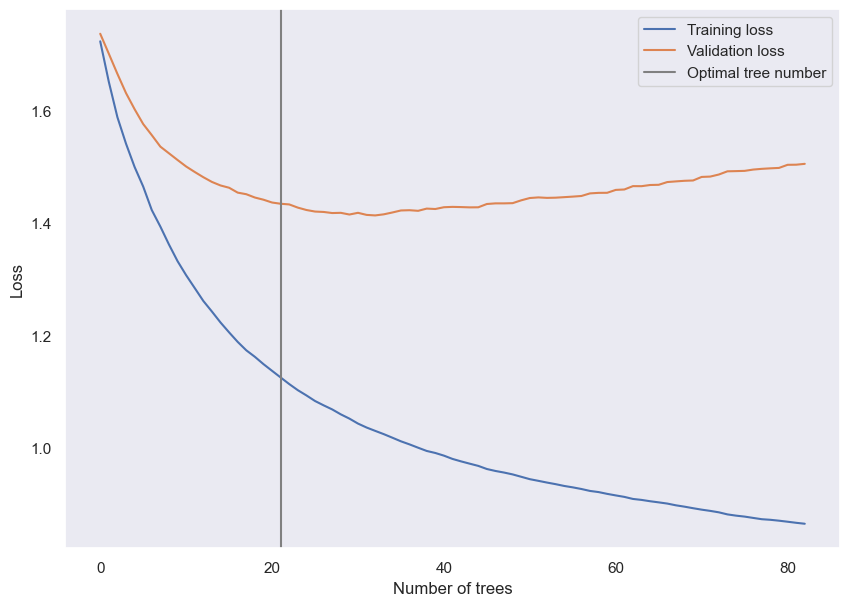

In [28]:
results2 = clf_3.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results2["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results2["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [29]:
clf_3.best_iteration

32

The optimal number of trees was selected just before the loss values started to increase for the validation data.

              precision    recall  f1-score   support

  No Drought       0.64      0.73      0.68     14698
          D0       0.20      0.07      0.11      5534
          D1       0.16      0.07      0.10      4074
          D2       0.15      0.34      0.21      2594
          D3       0.13      0.21      0.16      1888
          D4       0.00      0.00      0.00       612

    accuracy                           0.43     29400
   macro avg       0.21      0.24      0.21     29400
weighted avg       0.40      0.43      0.40     29400



<Figure size 400x400 with 0 Axes>

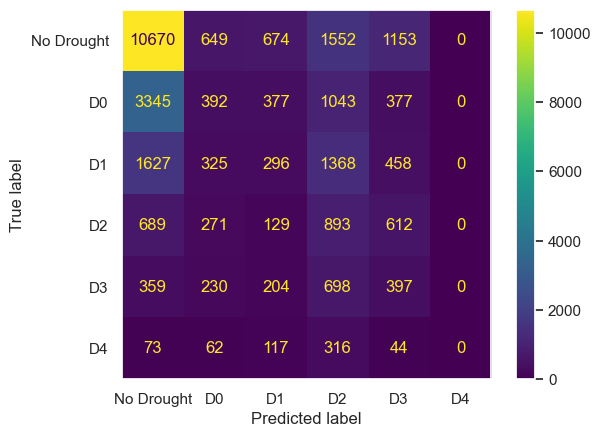

In [30]:
#make predictions
y_pred_3=clf_3.predict(x_test)
evaluate_model_performance(y_test,y_pred_3)

***
## 8. Hyperparameter tuning <a id='c-8'></a>
***

In [31]:

 param_test1 = {
  "n_estimators":[100,200,300,400],
  #"max_depth":[1,3,5,7],
  #"reg_lambda":[0, 0.001, 0.005, 0.01, 0.05],
  #"reg_alpha":[0.01,0.001,0.0001,0.00001],
  #"subsample":[0.5,0.6,0.7,0.8,0.9]
 }

tune_params(clf_3,x_train,y_train,param_test1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'n_estimators': 100}
Best Score: nan

CV Results:
Mean ROC AUC: nan, Params: {'n_estimators': 100}
Mean ROC AUC: nan, Params: {'n_estimators': 200}
Mean ROC AUC: nan, Params: {'n_estimators': 300}
Mean ROC AUC: nan, Params: {'n_estimators': 400}


In [39]:
 param_test1 = {
  #"n_estimators":[100,200,300,400],
  "max_depth":[1,3,5,7],
  #"reg_lambda":[0, 0.001, 0.005, 0.01, 0.05],
  #"reg_alpha":[0.01,0.001,0.0001,0.00001],
  #"subsample":[0.5,0.6,0.7,0.8,0.9]
 }

tune_params(clf_3,x_train,y_train,param_test1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best Parameters: {'max_depth': 1}
Best Score: nan

CV Results:
Mean ROC AUC: nan, Params: {'max_depth': 1}
Mean ROC AUC: nan, Params: {'max_depth': 3}
Mean ROC AUC: nan, Params: {'max_depth': 5}
Mean ROC AUC: nan, Params: {'max_depth': 7}


In [33]:
 param_test1 = {
  #"n_estimators":[100,200,300,400],
  #"max_depth":[1,3,5,7],
  "reg_lambda":[0, 0.001, 0.005, 0.01, 0.05],
  #"reg_alpha":[0.01,0.001,0.0001,0.00001],
  #"subsample":[0.5,0.6,0.7,0.8,0.9]
 }

tune_params(clf_3,x_train,y_train,param_test1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'reg_lambda': 0}
Best Score: nan

CV Results:
Mean ROC AUC: nan, Params: {'reg_lambda': 0}
Mean ROC AUC: nan, Params: {'reg_lambda': 0.001}
Mean ROC AUC: nan, Params: {'reg_lambda': 0.005}
Mean ROC AUC: nan, Params: {'reg_lambda': 0.01}
Mean ROC AUC: nan, Params: {'reg_lambda': 0.05}


In [34]:
 param_test1 = {
  #"n_estimators":[100,200,300,400],
  #"max_depth":[1,3,5,7],
  #"reg_lambda":[0, 0.001, 0.005, 0.01, 0.05],
  "reg_alpha":[0.01,0.001,0.0001,0.00001],
  #"subsample":[0.5,0.6,0.7,0.8,0.9]
 }

tune_params(clf_3,x_train,y_train,param_test1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'reg_alpha': 0.01}
Best Score: nan

CV Results:
Mean ROC AUC: nan, Params: {'reg_alpha': 0.01}
Mean ROC AUC: nan, Params: {'reg_alpha': 0.001}
Mean ROC AUC: nan, Params: {'reg_alpha': 0.0001}
Mean ROC AUC: nan, Params: {'reg_alpha': 1e-05}


In [37]:
 param_test1 = {
  #"n_estimators":[100,200,300,400],
  #"max_depth":[1,3,5,7],
  #"reg_lambda":[0, 0.001, 0.005, 0.01, 0.05],
  #"reg_alpha":[0.01,0.001,0.0001,0.00001],
  "subsample":[0.5,0.6,0.7,0.8,0.9]
 }

tune_params(clf_3,x_train,y_train,param_test1)

ValueError: 'mlogloss' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [ ]:
#final model


clf_fin = xgb.XGBClassifier(
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 reg_lambda=1,
 reg_alpha=0,
 scale_pos_weight=1,
 seed=27)


In [ ]:
# Fit the model, test sets are used for early stopping.
start = time.time()
eval_set = [(x_train,y_train),(x_test, y_test)]
clf_fin.fit(x_train, y_train,eval_metric="mlogloss",eval_set=eval_set, early_stopping_rounds=50,verbose=True)  #or auc when objective is set to multi:softprob

end = time.time()
print('Execution time for Training clf1:', end - start, "seconds")
# Save model into JSON format.
clf_fin.save_model("clf_FIN.json")

In [ ]:
resultsFIN = clf_fin.evals_result()

plt.figure(figsize=(10,7))
plt.plot(resultsFIN["validation_0"]["mlogloss"], label="Training loss")
plt.plot(resultsFIN["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

              precision    recall  f1-score   support

  No Drought       0.54      0.81      0.65     14698
          D0       0.17      0.22      0.19      5534
          D1       0.02      0.00      0.00      4074
          D2       0.00      0.00      0.00      2594
          D3       0.00      0.00      0.00      1888
          D4       0.00      0.00      0.00       612

    accuracy                           0.45     29400
   macro avg       0.12      0.17      0.14     29400
weighted avg       0.31      0.45      0.36     29400



<Figure size 400x400 with 0 Axes>

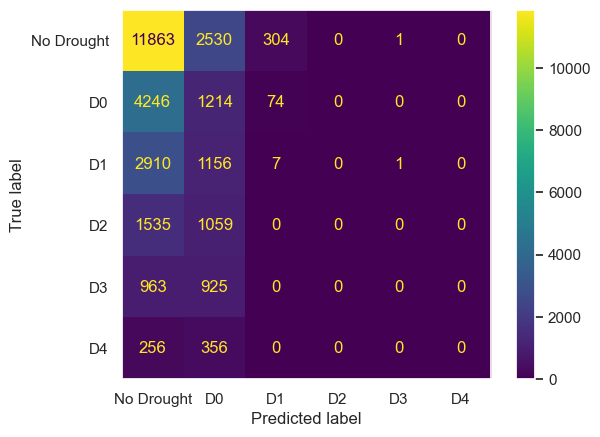

In [234]:
# make predictions for test data
y_pred_fin = clf_fin.predict(x_test)
# evaluate predictions
evaluate_model_performance(y_test,y_pred_fin)

***
## 9. Feature importance <a id='c-9'></a>
***

How useful were the features in the construction of the boosted trees. An attribute used more often to make decisions in the tree would be considered more important.

In [43]:
feature_names = train_df.columns.delete(train_df.columns.get_loc('score')).tolist()
print(feature_names)

['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND', 'doy', 'year', 'SQ1_2', 'SQ1_3', 'SQ1_6', 'SQ1_7', 'SQ2_2', 'SQ2_3', 'SQ2_6', 'SQ2_7', 'SQ3_2', 'SQ3_3', 'SQ3_4', 'SQ3_6', 'SQ3_7', 'SQ4_2', 'SQ4_6', 'SQ4_7', 'SQ5_2', 'SQ5_3', 'SQ5_4', 'SQ5_6', 'SQ5_7', 'SQ6_2', 'SQ6_3', 'SQ6_6', 'SQ6_7', 'SQ7_2', 'SQ7_3', 'SQ7_4', 'SQ7_6', 'SQ7_7']


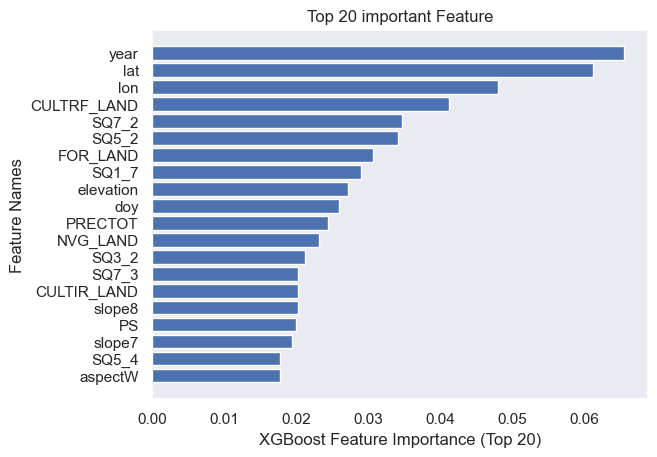

In [45]:
from sklearn.inspection import permutation_importance
clf_3.feature_importances_
sorted_idx = clf_3.feature_importances_.argsort()

# Plot the top 20 features
top_20_idx = sorted_idx[-20:]
plt.barh(range(len(top_20_idx)), clf_3.feature_importances_[top_20_idx])
plt.yticks(range(len(top_20_idx)), [feature_names[i] for i in top_20_idx])
plt.xlabel("XGBoost Feature Importance (Top 20)")
plt.ylabel("Feature Names")
plt.show()

***
## 10. References <a id='c-10'></a>
***

https://machinelearningmastery.com/xgboost-python-mini-course/
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
https://mljar.com/blog/feature-importance-xgboost/
https://xgboost.readthedocs.io/en/latest/python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://scikit-learn.org/stable/modules/model_evaluation.html
https://mljar.com/blog/xgboost-early-stopping/
https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
https://scikit-learn.org/stable/modules/learning_curve.html
https://stats.stackexchange.com/questions/575592/difference-k-fold-versus-blocked-cross-validation
https://365datascience.com/tutorials/python-tutorials/xgboost-lgbm/